In [11]:
!export JAX_PLATFORMS=cpu
import tszpower
from classy_sz import Class as Class_sz
import jax
import jax.numpy as jnp 
import numpy as np
import torch
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.analysis import pairplot
# from sbi.inference import NPE
# from sbi.inference import NLE
from sbi.inference import NRE_A
# from sbi.inference import FMPE
import matplotlib.pyplot as plt

/usr/lib64/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [12]:
# --- Define the Prior ---
# We need a 9-dimensional prior (one for each free parameter).
# Order: [logA, omega_b, omega_cdm, H0, n_s, B, A_cib, A_rs, A_ir]

low = torch.tensor([2.5,   0.02,  0.11, 55.,  0.94, 1.0, 0.0, 0.0, 0.0])
high = torch.tensor([3.5, 0.025, 0.13, 90.,  1.0,  2.0, 5.0, 5.0, 5.0])
prior = BoxUniform(low=low, high=high)

In [13]:
data_file = np.loadtxt("data/data_ps-ell-y2-erry2_total-planck-collab-15.txt")
x_o = data_file[:, 1]
# x_o

In [14]:
inference = NRE_A(prior)
theta = torch.load('sbi_sim_data/theta_3ksamps.pt')
x = torch.load('sbi_sim_data/x_3ksamps.pt')
_ = inference.append_simulations(theta, x).train(show_train_summary=True)
posterior = inference.build_posterior().set_default_x(x_o)

/tmp/ipykernel_2132885/2563308742.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta = torch.load('sbi_sim_data/theta_3ksamps.pt')
/tmp/ipykernel_2132885/2563308742.p

 Neural network successfully converged after 139 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 139
        Best validation performance: 0.0001
        -------------------------
        


In [15]:
samples = posterior.sample((10000,), x=x_o)
print(samples)
np.savetxt('samples_NRE_3000.txt', samples.numpy())

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

tensor([[3.1520, 0.0206, 0.1137,  ..., 0.1554, 0.1288, 2.4459],
        [3.1320, 0.0230, 0.1126,  ..., 0.2580, 0.1318, 2.2734],
        [3.0784, 0.0214, 0.1125,  ..., 0.3711, 0.1343, 2.0320],
        ...,
        [2.9900, 0.0247, 0.1207,  ..., 0.6114, 2.2918, 0.1052],
        [3.0160, 0.0232, 0.1180,  ..., 0.5239, 2.1980, 0.1741],
        [2.9797, 0.0245, 0.1174,  ..., 0.6211, 1.9922, 0.3208]])


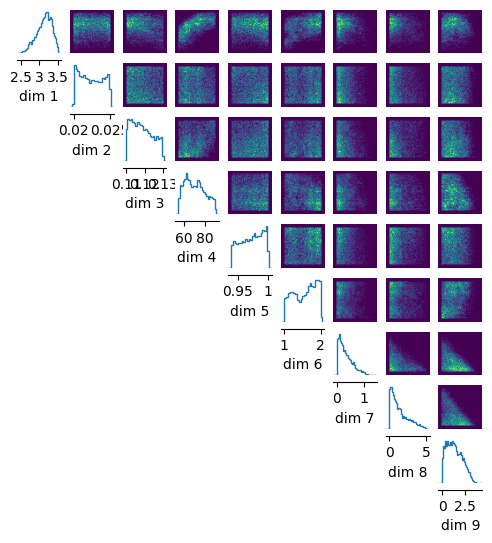

In [16]:
_ = pairplot(samples,
             # limits=[[-2, 2], [-2, 2], [-2, 2]],
             figsize=(6, 6),)
             # labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

 Neural network successfully converged after 67 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 67
        Best validation performance: 0.0003
        -------------------------
        


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

tensor([[3.0587, 0.0228, 0.1155,  ..., 0.0201, 3.8012, 0.4605],
        [3.0609, 0.0233, 0.1272,  ..., 0.0096, 4.0070, 0.0042],
        [3.1464, 0.0241, 0.1284,  ..., 0.0290, 3.7148, 0.0575],
        ...,
        [3.2197, 0.0205, 0.1150,  ..., 0.4679, 1.2931, 1.0170],
        [3.1665, 0.0225, 0.1161,  ..., 0.6565, 1.0207, 0.8223],
        [3.1797, 0.0248, 0.1237,  ..., 0.2811, 0.5279, 1.8964]])


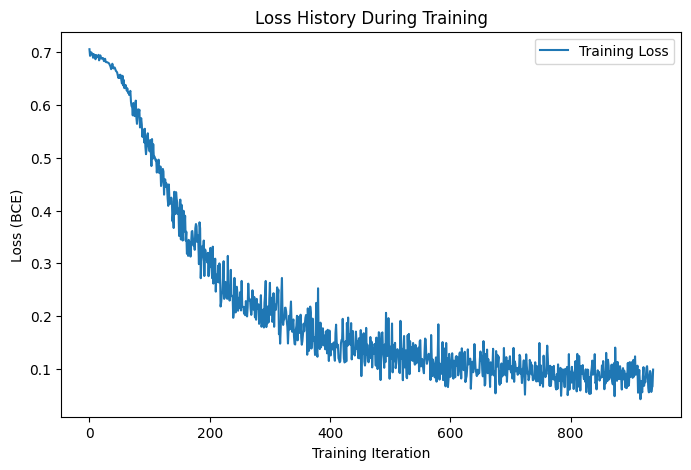

In [17]:
# Global list to store loss values
loss_history = []

# Subclass NRE_A to intercept the loss computation
class NRE_A_WithLoss(NRE_A):
    def _loss(self, theta: torch.Tensor, x: torch.Tensor, num_atoms: int) -> torch.Tensor:
        # Compute the loss using the parent class method
        loss = super()._loss(theta, x, num_atoms)
        # Record the loss value (as a scalar)
        loss_history.append(loss.item())
        return loss


# Create an instance of the subclassed estimator
inference = NRE_A_WithLoss(prior)

# # Load your simulation data
# theta = torch.load('theta_2ksamps.pt')
# x = torch.load('x_2ksamps.pt')

# Append the simulations and train the classifier. 
# (The training routine will call our overridden _loss and record loss values.)
_ = inference.append_simulations(theta, x).train(show_train_summary=True)

# (Optionally) Build the posterior and sample from it
# x_o = ...  # your observation, e.g. x_o = some_tensor_of_observed_data
posterior = inference.build_posterior().set_default_x(x_o)
samples = posterior.sample((10000,), x=x_o)
print(samples)

# Plot the loss history
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Training Iteration')
plt.ylabel('Loss (BCE)')
plt.title('Loss History During Training')
plt.legend()
plt.show()

In [18]:
# print(len(loss_history))

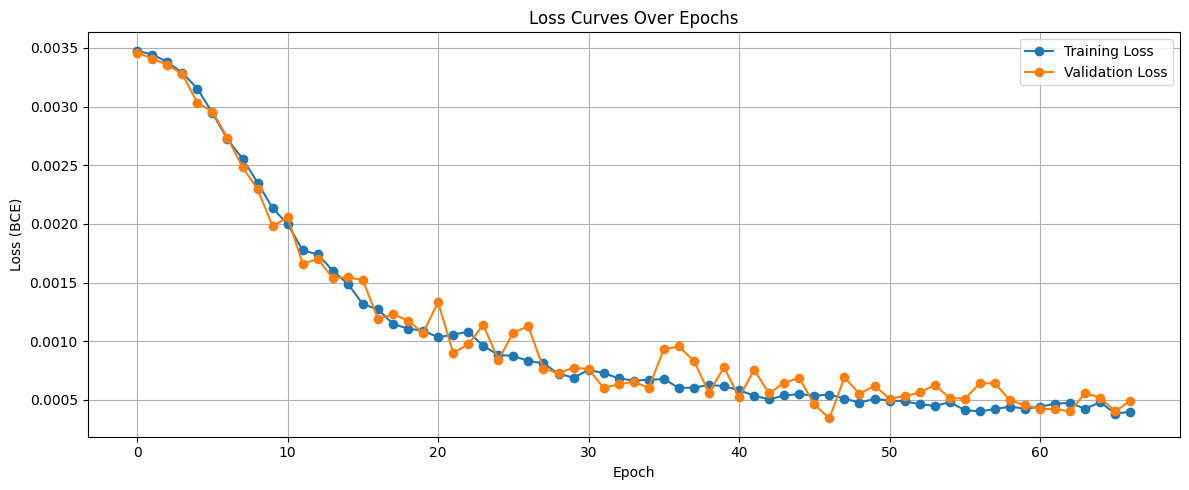

In [19]:
# import torch
# import matplotlib.pyplot as plt

# Assume 'inference' is your trained NRE_A object.
# The training process stores loss values in inference._summary:
train_loss_history = inference._summary["training_loss"]
val_loss_history = inference._summary["validation_loss"]

# Plot training and validation loss over epochs.
plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Training Loss", marker="o")
plt.plot(val_loss_history, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss (BCE)")
plt.title("Loss Curves Over Epochs")
plt.legend()
plt.grid(True)

# --- Compute Classifier Accuracy on a held-out batch ---
def compute_accuracy(theta: torch.Tensor, x: torch.Tensor, net: torch.nn.Module, device: str, num_atoms: int = 2) -> float:
    """
    Compute classification accuracy for the NRE_A classifier.
    The classifier is trained on alternating pairs:
      - Joint samples are labeled as 1.
      - Marginal samples are labeled as 0.
    """
    net.eval()
    with torch.no_grad():
        # Compute logits using the _classifier_logits helper
        logits = inference._classifier_logits(theta, x, num_atoms)
        probabilities = torch.sigmoid(logits).squeeze()  # shape: (2 * batch_size,)
        batch_size = theta.shape[0]
        # Construct true labels: alternating 1, 0, 1, 0, ...
        true_labels = torch.ones(2 * batch_size, device=device)
        true_labels[1::2] = 0.0
        # Binary predictions: threshold at 0.5
        preds = (probabilities > 0.5).float()
        correct = (preds == true_labels).sum().item()
        total = true_labels.numel()
    return correct / total

# # Get a batch from the most recent simulations.
# # (Assumes that _theta_roundwise and _x_roundwise have been stored during simulation appending.)
# theta_batch = inference._theta_roundwise[-1]
# x_batch = inference._x_roundwise[-1]
# print(theta_batch.shape, x_batch.shape)
# accuracy = compute_accuracy(theta_batch, x_batch, inference._neural_net, inference._device, num_atoms=2)

# # Plot the classifier accuracy.
# plt.subplot(1, 2, 2)
# plt.bar(["Classifier Accuracy"], [accuracy], color="skyblue")
# plt.ylim(0, 1)
# plt.ylabel("Accuracy")
# plt.title("Classifier Accuracy on Latest Batch")
# plt.grid(True, axis='y')

plt.tight_layout()
plt.show()
